# Spiral Problem

This document presents a fictitious problem of learning the length of a spiral;

The equation of the features $x_1$ and $x_2$ and target is given by:
\begin{eqnarray}
    x_1 &=& \theta \cos(\theta) + \epsilon_1 ~~~~~~ x_2 = \theta \sin(\theta) + \epsilon_2 \\
    y &=& \frac{1}{2}\left[ \theta \sqrt{1+\theta^2}+ \sinh^{-1} \theta \right] \nonumber
    \label{eq:spiral}   
\end{eqnarray}
where $x = (x_1, x_2)$ is a point in the Cartesian plane defined by the spiral representing the features $x_1$ and $x_2$, $\theta$ is an independent variable, $\epsilon_i$ ($i \in {1, 2}$) is random noise, and the target value is given by $y$, which is the length of the spiral calculated at a point $x$. This toy model presents some interesting features for our analysis, such as the feature domain over the spiral and the substantial variance of the target value when varying one of the features' coordinates while keeping the other one fixed.

In [1]:
import sys, os
sys.path.append('..')

import pickle
import numpy as np
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
import lime.lime_tabular

from sklearn.model_selection import train_test_split
from sklearn.linear_model import HuberRegressor as Linear

# Data - Toy Model Length Spiral
from domain import Spiral
from m_lime.explainers.explainer_linear import Explainer
from m_lime.generators.kde_gen import KDEGen
from m_lime.explainers.visualizations.plot_importance import ExplainGraph

# Data spiral

In [2]:
data = Spiral(n_samples=10000, theta_domain=[2*np.pi, 2.5*np.pi], error_x=0.1)

In [3]:
x_train, x_test, y_train, y_test = train_test_split(data.data, data.target, train_size=0.80)

# Training a MLP Model

In [4]:
model = make_pipeline(
    StandardScaler(),
    MLPRegressor(
        solver='lbfgs',random_state=1, max_iter=10000, early_stopping=True,
        alpha=0.01,
        hidden_layer_sizes=[50, 50, 50, 50, 50]
))

In [5]:
filename = 'mlp_model_spiral.bin'
if os.path.exists(filename):
    model = pickle.load(open(filename, 'rb'))
else:
    model.fit(x_train, y_train)
    pickle.dump(model, open(filename, 'wb'))

In [6]:
print('R2: ', metrics.r2_score(y_test, model.predict(x_test)))
print('MSE: ', metrics.mean_squared_error(y_test, model.predict(x_test)))

R2:  0.9999820299564488
MSE:  0.009945190996030171


# Interpretation and Explanation

In [7]:
categorical_features = np.argwhere(np.array([len(set(data.data[:,x])) for x in range(data.data.shape[1])]) <= 10).flatten()
categorical_features

array([], dtype=int64)

## Explanation for instance x<sup>1</sup> = (0.0, 8.5):

For point $x^*$, the target value (the length of the spiral) will locally depend on the value of $x_1$. Thus the explanation methods should indicate that variable as the most important.

In [8]:
x_explain = np.array([[0.0, 8.0]])

x_explain: [[0. 8.]]
Predict Lenght: 32.5500


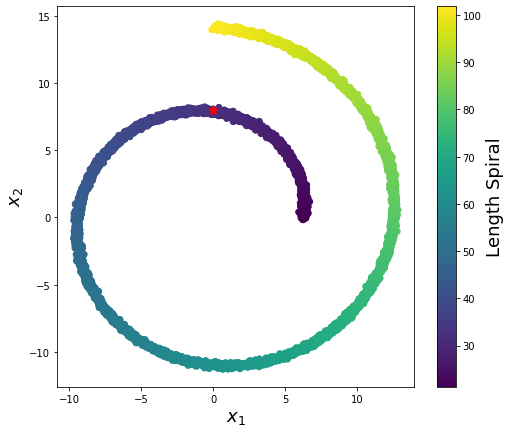

In [9]:
fig, ax = data.plot()
cp = ax.scatter(x_explain[:, 0], x_explain[:, 1], s=100, c='red', marker="*")
fig.set_size_inches(8,7)
plt.xlabel('$x_1$', fontsize=18)
plt.ylabel('$x_2$', fontsize=18)
print(f'x_explain: {x_explain}')
print(f'Predict Lenght: {model.predict(np.array([[0.0, 8.0]]))[0]:5.4f}')

### Normal Lime

In [10]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    x_train, feature_names=data.feature_names,
    class_names=['legth'], categorical_features=categorical_features,
    verbose=True, mode='regression', discretize_continuous=False)

In [11]:
exp = explainer.explain_instance(x_explain[0], model.predict)

Intercept 43.206865737253516
Prediction_local [52.97180192]
Right: 32.55003354460349


In [12]:
# Dictionary for plot the explanation
explanation = dict(
    chi_names=exp.domain_mapper.feature_names,
    chi_values=np.array(x_explain),
    x_values=exp.domain_mapper.feature_names,
    x_names=exp.domain_mapper.feature_values,
    y_p=model.predict(np.array([[0.0, 8.0]]))[0],
    y_p_max=exp.max_value,
    y_p_min=exp.min_value,
    y_p_local_model=exp.local_pred[0],
    y_p_local_model_max=None,
    y_p_local_model_min=None,
    error=None,
    importances=[e[1] for e in exp.as_list()],
    diff_convergence_importances=None,
    ind_class_sorted=0,
    class_names= ["lenght"]
)

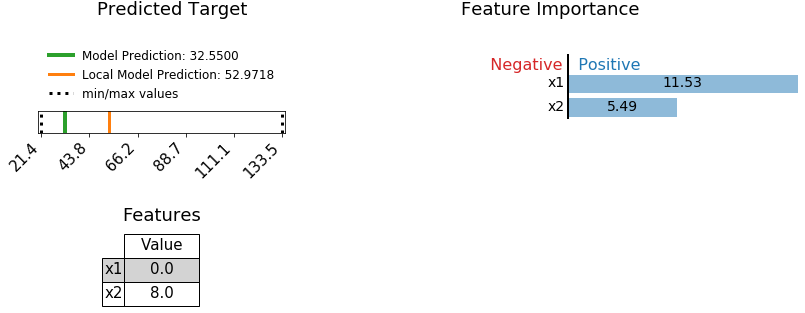

In [13]:
fig, axs = ExplainGraph.plot(explanation)
plt.savefig(f'spiral_x_{x_explain}_lime.png', dpi=300)

The local prediction does not agree with the ML model predictions (difference of $\approx 20$), which decreases the trust of the produced explanation. Despite that, the produced explanation is not correct. The feature importance is positive for both features $x_1$ and $x_2$. While a decrease in the $x_1$ should locally increase the spiral length.

In [14]:
# exp.show_in_notebook(show_table=True)

### m-lime using KDEGen

Now, we use Kernel Density Estimation (KDE) to obtain an estimative of the manifold of the feature space. Then, the interpretation is produced from samples drawn from this estimative close from the instance x<sup>1</sup>

In [15]:
generator = KDEGen(verbose=True).fit(x_train)

Best Parameter for the KDE:
{'bandwidth': 0.08315789473684211}
Score: -5728.405998780594


In [16]:
x_set = generator.sample_radius(x_explain, r=1.0, n_samples=500)

#### Visualization of the sampled data:

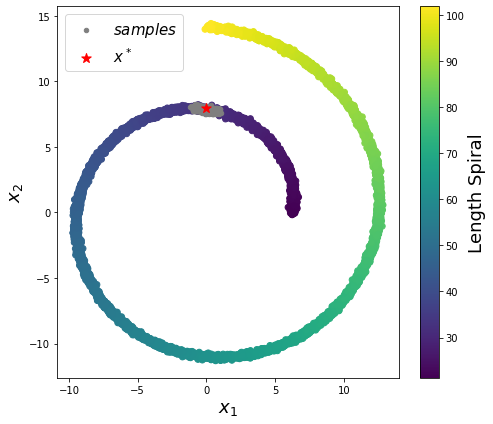

In [17]:
fig, ax = data.plot()
cp = ax.scatter(x_set[:, 0], x_set[:, 1], s=20, c='tab:gray', alpha=1.0, label='$samples$')
cp = ax.scatter(
    x_explain[:, 0], x_explain[:, 1], s=100, c='red', marker="*", label='$x^*$')
fig.set_size_inches(7,6)
plt.xlabel('$x_1$', fontsize=18)
plt.ylabel('$x_2$', fontsize=18)
plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig('figure.png', dpi=300)

### Using a Ridge Regression as local model

In [18]:
explainer = Explainer(
    model_predict=model.predict,
    generator=generator, 
    local_model='Ridge', 
    feature_names=data.feature_names
)
explanation, counterfactual_examples = explainer.explain_instance(
    x_explain=x_explain.reshape(1, -1),
    r=1.0,
    n_samples=1000,
    tol_importance=0.01,
    local_mini_batch_max=20,
    scale_data=False,
    weight_kernel='gaussian'
)

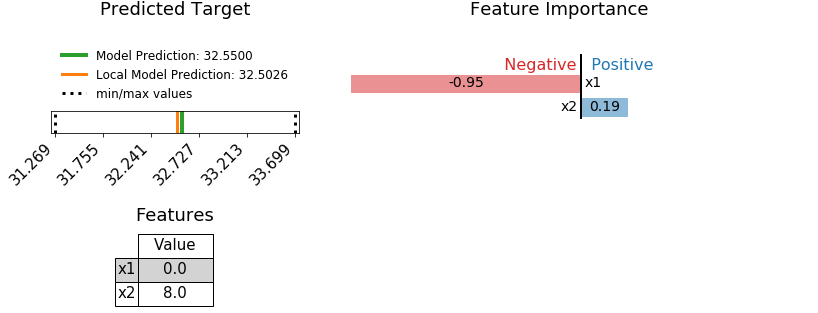

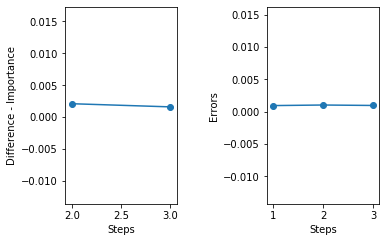

In [19]:
fig, axs = ExplainGraph.plot(explanation.explain())
plt.savefig(f'spiral_x_{x_explain}_m-lime_kde.png', dpi=300)
fig, axs = ExplainGraph.plot_errors(explanation)

### Using a HuberRegressor as local model 

In [20]:
explainer = Explainer(
    model_predict=model.predict,
    generator=generator, 
    local_model='HuberRegressor', 
    feature_names=data.feature_names
)
explanation, counterfactual_examples = explainer.explain_instance(
    x_explain=x_explain.reshape(1, -1),
    r=1.0,
    n_samples=1000,
    tol_importance=0.01,
    local_mini_batch_max=20,
    scale_data=False,
    weight_kernel='gaussian'
)

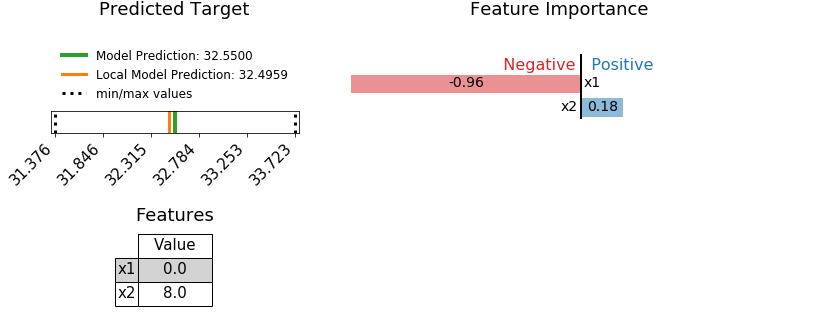

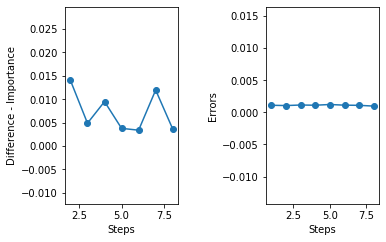

In [21]:
fig, axs = ExplainGraph.plot(explanation.explain())
fig, axs = ExplainGraph.plot_errors(explanation)

### Using a SGD Regressor as local model 

In [22]:
explainer = Explainer(
    model_predict=model.predict,
    generator=generator, 
    local_model='SGD', 
    feature_names=data.feature_names
)
explanation, counterfactual_examples = explainer.explain_instance(
    x_explain=x_explain.reshape(1, -1),
    r=1.0,
    n_samples=500,
    tol_importance=0.01,
    local_mini_batch_max=20,
    scale_data=True,
    weight_kernel='gaussian'
)

../m_lime/explainers/explainer.py:186: UserWarning: Convergence tolerance (tol) was not achieved!
Current difference in the importance 0.0018544015689381278/0.01
Current Error: 0.1544324445443264/0.01
  + f"Current Error: {error_local_model}/{tol_importance}"


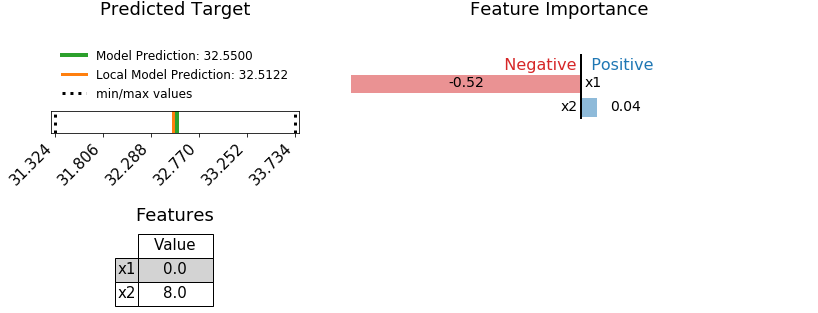

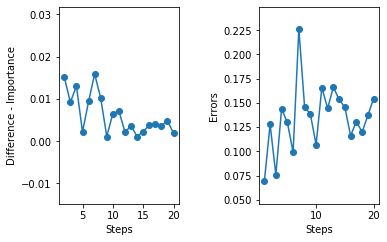

In [23]:
fig, axs = ExplainGraph.plot(explanation.explain())
fig, axs = ExplainGraph.plot_errors(explanation)

Thank you!